# Reinforcement Learning: Assignment 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Visualize the grid world
def plot_grid_world(grid_world, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.imshow(1-grid_world, cmap='gray', interpolation='nearest')
    plt.title("Grid World")
    plt.xticks([])
    plt.yticks([])
    plt.show()


# Visualize the grid world, state value function, and policy
def plot_policy(grid_world, policy=None, figsize=(10,3), title="Policy"):
    plt.figure(figsize=figsize)
    
    if policy is not None:
        plt.imshow(1-grid_world, cmap='gray')
        n_x, n_y, n_a = policy.shape
        for i in range(n_x):
            for j in range(n_y):
                if grid_world[i, j] == 1 or grid_world[i, j] == 2:
                    continue
                if policy[i, j, 0] > 0:
                    plt.arrow(j, i,      0 * policy[i, j, 0], -0.5 * policy[i,j,0], head_width=0.1, head_length=0.1, fc='r', ec='r')
                if policy[i, j, 1] > 0:
                    plt.arrow(j, i,    0.5 * policy[i, j, 1],    0 * policy[i,j,1], head_width=0.1, head_length=0.1, fc='r', ec='r')
                if policy[i, j, 2] > 0:
                    plt.arrow(j, i,      0 * policy[i, j, 2], +0.5 * policy[i,j,2], head_width=0.1, head_length=0.1, fc='r', ec='r')
                if policy[i, j, 3] > 0:
                    plt.arrow(j, i,   -0.5 * policy[i, j, 3],    0 * policy[i,j,3], head_width=0.1, head_length=0.1, fc='r', ec='r')
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

    plt.show()

### Expected Sarsa

#### Expected Sarsa: $\epsilon$-greedy policy from Q

In [2]:
def next_epsilon_greedy_action(Q=None, S=(0,0), epsilon=0.5):
    if np.random.rand() < epsilon: return np.random.randint(4)
    else: return np.argmax(Q[S])

def expected_next_action(Q=None, S=(0,0), epsilon=0.5):
    A_max = np.argmax(Q[S])
    return sum(Q[S])*epsilon/len(Q[S])+(1-epsilon)*Q[S][A_max]

def expected_sarsa(step_size=0.01, gamma=1.0, epsilon=0.1, n_episodes=1000):
    # Initialize Q(s,a)
    Q = np.ones((4,12,4))*-3
    Q[3,11] = 0

    for n in range(n_episodes):
        # Fixed initial state
        S = (3,0)
        
        # Repeat for each step of episode
        while S != (3,11):
            # Choose A from S using epsilon-greedy derived from Q
            A = next_epsilon_greedy_action(Q, S, epsilon)
            
            # Take action A, observe R, S'
            if S[0] == 3 and 1 <= S[1] <= 10:
                S_next = (3,0)
                R = -100
            else:
                if A == 0:      S_next = (max(0, S[0]-1), S[1])
                elif A == 1:    S_next = (S[0], min(11, S[1]+1))
                elif A == 2:    S_next = (min(3, S[0]+1), S[1])
                elif A == 3:    S_next = (S[0], max(0, S[1]-1))
                R = -1

            # Q update
            expected_sum = expected_next_action(Q, S_next, epsilon)
            Q[S][A] += step_size * (R + gamma*expected_sum - Q[S][A])

            # Update S
            S = S_next

    policy = np.zeros((4,12,4))
    for i in range(4):
        for j in range(12):
            idx = np.argmax(Q[i,j])
            policy[i,j,idx] = 1
    
    return policy

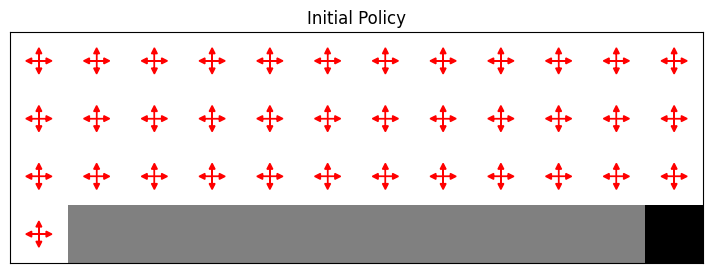

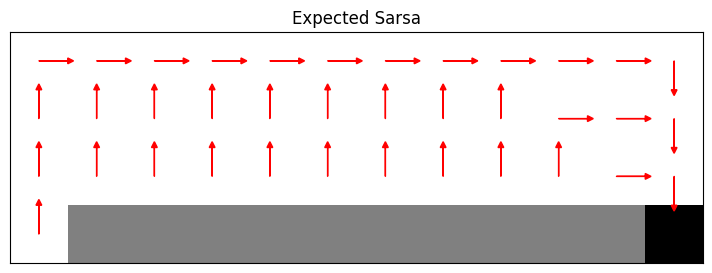

In [24]:
# Grid world with cliff                         4x12 Matrix
grid_world = np.zeros((4,12))
grid_world[3,11] = 2            # goal
grid_world[3,1:11] = 1          # cliff


policy = np.ones((4,12,4))/4
plot_policy(grid_world, policy, title="Initial Policy")
policy = expected_sarsa(step_size=0.1, epsilon=0.5, n_episodes=10000)
plot_policy(grid_world, policy, title="Expected Sarsa")

#### Expected Sarsa: $\epsilon$-softmax policy from Q

In [4]:
def softmax(Q, tau=1.0):
    return np.exp(Q/tau)/np.sum(np.exp(Q/tau))

def next_softmax_action(Q=None, S=(0,0), tau=1.0, epsilon=0.1):
    return np.random.choice(4, p=softmax(Q[S], tau)*(1-epsilon)+epsilon/4*np.ones(4))

def expected_Q(Q=None, S=(0,0), tau=1.0, epsilon=0.1):
    return sum(Q[S]*(softmax(Q[S], tau)*(1-epsilon)+epsilon/4*np.ones(4)))

def expected_softmax_sarsa(step_size=0.01, gamma=1.0, tau=1.0, epsilon=0.5, n_episodes=1000):
    # Initialize Q(s,a)
    Q = np.ones((4,12,4))*-3
    Q[3,11] = 0

    for n in range(n_episodes):
        # Fixed initial state
        S = (3,0)
        
        # Repeat for each step of episode
        while S != (3,11):
            # Choose A from S using softmax policy derived from Q
            A = next_softmax_action(Q, S, tau, epsilon)
            
            # Take action A, observe R, S'
            if S[0] == 3 and 1 <= S[1] <= 10:
                S_next = (3,0)
                R = -100
            else:
                if A == 0:      S_next = (max(0, S[0]-1), S[1])
                elif A == 1:    S_next = (S[0], min(11, S[1]+1))
                elif A == 2:    S_next = (min(3, S[0]+1), S[1])
                elif A == 3:    S_next = (S[0], max(0, S[1]-1))
                R = -1

            # Q update
            expected_sum = expected_Q(Q, S_next, tau, epsilon)
            Q[S][A] += step_size * (R + gamma*expected_sum - Q[S][A])

            # Update S
            S = S_next

    policy = np.zeros((4,12,4))
    for i in range(4):
        for j in range(12):
            idx = np.argmax(Q[i,j])
            policy[i,j,idx] = 1
    
    return policy

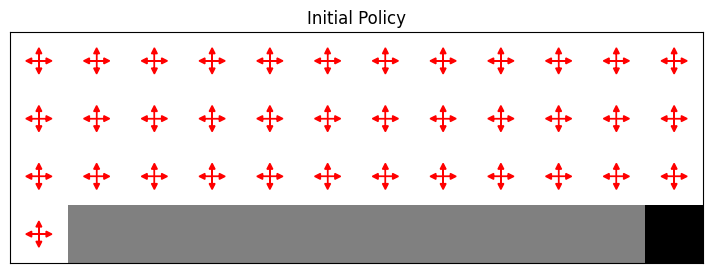

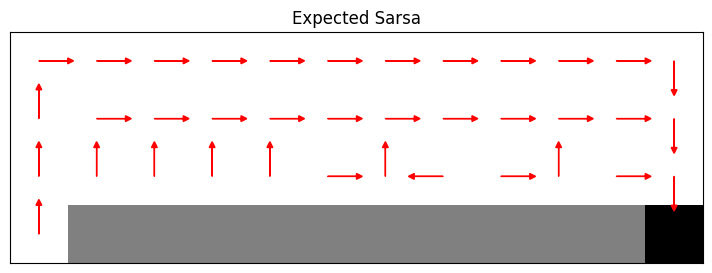

In [22]:
# Grid world with cliff                         4x12 Matrix
grid_world = np.zeros((4,12))
grid_world[3,11] = 2            # goal
grid_world[3,1:11] = 1          # cliff


policy = np.ones((4,12,4))/4
plot_policy(grid_world, policy, title="Initial Policy")
policy = expected_softmax_sarsa(step_size=0.1, tau=1, epsilon=0.5, n_episodes=200)
plot_policy(grid_world, policy, title="Expected Sarsa")

### Double Q-learning

![Double Q Learning.png](<attachment:Double Q Learning.png>)
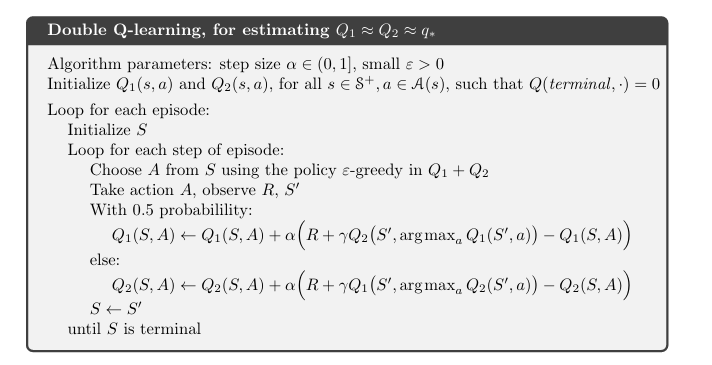

In [16]:
def next_epsilon_greedy_action(Q=None, S=(0,0), epsilon=0.5):
    if np.random.rand() < epsilon: return np.random.randint(4)
    else: return np.argmax(Q[S])

def double_Q_learning(step_size=0.9, gammma=1.0, epsilon=0.1, n_episodes=1000):
    # Initialize Q_1 and Q_2
    Q_1= np.ones((4,12,4))*-3
    Q_2= np.ones((4,12,4))*-3
    Q_1[3,11] = 0
    Q_2[3,11] = 0

    for _ in range(n_episodes):
        # Fixed initial state
        S = (3,0)
        
        # Repeat for each step of episode
        while S != (3,11):
            # Choose A from S using epsilon-greedy derived from Q_1 + Q_2
            A = next_epsilon_greedy_action(Q_1+Q_2, S, epsilon)
            
            # Take action A, observe R, S'
            if S[0] == 3 and 1 <= S[1] <= 10:
                S_next = (3,0)
                R = -100
            else:
                if A == 0:      S_next = (max(0, S[0]-1), S[1])
                elif A == 1:    S_next = (S[0], min(11, S[1]+1))
                elif A == 2:    S_next = (min(3, S[0]+1), S[1])
                elif A == 3:    S_next = (S[0], max(0, S[1]-1))
                R = -1
            
            # Q update
            if np.random.rand() < 0.5:
                Q_1[S][A] += step_size * (R + gammma*Q_2[S_next][np.argmax(Q_1[S_next])] - Q_1[S][A])
            else:
                Q_2[S][A] += step_size * (R + gammma*Q_1[S_next][np.argmax(Q_2[S_next])] - Q_2[S][A])
            
            # Update S
            S = S_next

    policy = np.zeros((4,12,4))
    for i in range(4):
        for j in range(12):
            idx = np.argmax(Q_1[i,j]+Q_2[i,j])
            policy[i,j,idx] = 1

    return policy

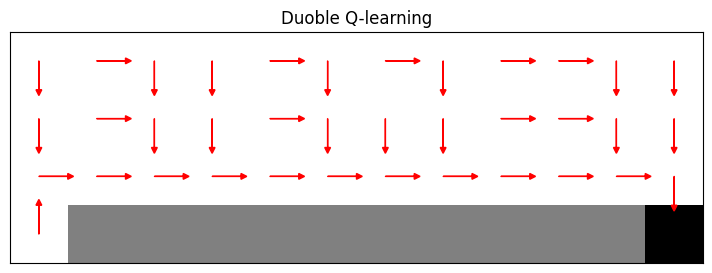

In [19]:
# Grid world with cliff                         4x12 Matrix
grid_world = np.zeros((4,12))
grid_world[3,11] = 2            # goal
grid_world[3,1:11] = 1          # cliff


policy = double_Q_learning(step_size=0.1, epsilon=0.5, n_episodes=1000)
plot_policy(grid_world, policy, title="Duoble Q-learning")

### Speedy Q-learning

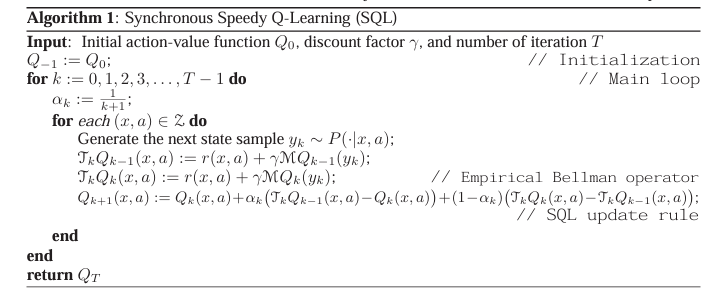

In [8]:
def next_epsilon_greedy_action(Q=None, S=(0,0), epsilon=0.5):
    if np.random.rand() < epsilon: return np.random.randint(4)
    else: return np.argmax(Q[S])

def speedy_Q_learning(step_size=0.9, gamma=1.0, epsilon=0.1, n_iter=100):
    # Initialize Q(s,a)
    Q0 = np.ones((4,12,4))*-3
    Q0[3,11] = 0
    Q1 = np.ones((4,12,4))*-3
    Q1[3,11] = 0
    Q2 = np.ones((4,12,4))*-3
    Q2[3,11] = 0

    for k in range(n_iter):
        alpha = 1/(k+1)
        
        # Repeat for each state action pair
        for s_x in range(Q0.shape[0]):
            for s_y in range(Q0.shape[1]):
                for a in range(Q0.shape[2]):
                    # Take action A, observe R, S'
                    S = (s_x, s_y)
                    A = a

                    if S == (3,11):
                        break
                    elif S[0] == 3 and 1 <= S[1] <= 10:
                        S_next = (3,0)
                        R = -100
                    else:
                        if A == 0:      S_next = (max(0, S[0]-1), S[1])
                        elif A == 1:    S_next = (S[0], min(11, S[1]+1))
                        elif A == 2:    S_next = (min(3, S[0]+1), S[1])
                        elif A == 3:    S_next = (S[0], max(0, S[1]-1))
                        R = -1

                    # Q update
                    B0 = R + gamma*np.max(Q0[S_next])
                    B1 = R + gamma*np.max(Q1[S_next])
                    Q0 = Q1.copy()
                    Q1[S][A] = Q1[S][A] + alpha*(B0 - Q1[S][A]) + (1-alpha)*(B1 - B0)

                    # Update S
                    S = S_next

    policy = np.zeros((4,12,4))
    for i in range(4):
        for j in range(12):
            idx = np.argmax(Q1[i,j])
            policy[i,j,idx] = 1

    return policy

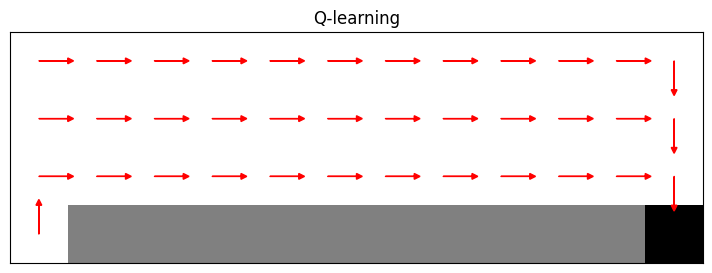

In [9]:
# Grid world with cliff                         4x12 Matrix
grid_world = np.zeros((4,12))
grid_world[3,11] = 2            # goal
grid_world[3,1:11] = 1          # cliff


policy = speedy_Q_learning(step_size=0.1, epsilon=0.5, n_iter=500)
plot_policy(grid_world, policy, title="Q-learning")